In [1]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import regularizers

Train_preprocessing

In [2]:
df = pd.read_csv('train_csv.csv')
df.head()

,fname,label
0,0001-2.wav,healthy
1,0002-1.wav,healthy
2,0002-2.wav,healthy
3,0002-3.wav,healthy
4,0002-4.wav,healthy


In [3]:
df = df[df['label'].isin(['wheezing','healthy'])]

In [4]:
path = 'train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i], sr=48000))
audio_data = np.array(audio_data)

100%|██████████| 211/211 [00:01<00:00, 169.28it/s]
<ipython-input-4-0d9f16771634>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_data = np.array(audio_data)


In [5]:
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,audio_waves,samplerate
0,0001-2.wav,healthy,"[1.3626541e-05, 2.4268042e-05, 4.2594587e-05, ...",48000
1,0002-1.wav,healthy,"[-5.902758e-05, -0.00015456039, -7.695286e-05,...",48000
2,0002-2.wav,healthy,"[1.8155406e-05, 1.851782e-05, -1.3286949e-05, ...",48000
3,0002-3.wav,healthy,"[5.6738895e-06, 6.578397e-05, 5.494365e-06, -4...",48000
4,0002-4.wav,healthy,"[0.0001540475, 9.0390386e-05, -1.634133e-05, 6...",48000


In [6]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,audio_waves,samplerate,bit_lengths,second_lengths
0,0001-2.wav,healthy,"[1.3626541e-05, 2.4268042e-05, 4.2594587e-05, ...",48000,202847,4.225979
1,0002-1.wav,healthy,"[-5.902758e-05, -0.00015456039, -7.695286e-05,...",48000,387790,8.078958
2,0002-2.wav,healthy,"[1.8155406e-05, 1.851782e-05, -1.3286949e-05, ...",48000,276383,5.757979
3,0002-3.wav,healthy,"[5.6738895e-06, 6.578397e-05, 5.494365e-06, -4...",48000,372239,7.754979
4,0002-4.wav,healthy,"[0.0001540475, 9.0390386e-05, -1.634133e-05, 6...",48000,294239,6.129979


In [7]:
df = df[df['second_lengths'] >= 2.0]

In [8]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)

104735
2.181979166666667


In [9]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [10]:
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [11]:
num_samples = 2000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 2000/2000 [00:02<00:00, 967.06it/s]


In [12]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i], samplerate=48000, nfft=2048))
mfcc_features = np.array(mfcc_features)

100%|██████████| 1993/1993 [00:36<00:00, 54.31it/s]


In [13]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(1993, 104735)
(1993, 217, 13)


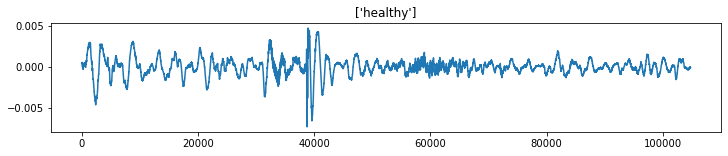

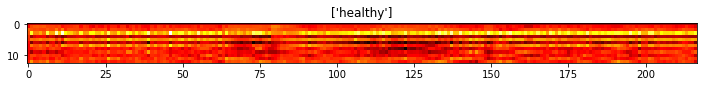

In [14]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [15]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[0 1 0 ... 1 0 1]


/home/nextgen/anaconda3/envs/kbs_coin/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [17]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
print(one_hot_encoded)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [18]:
X_train = mfcc_features
y_train = one_hot_encoded

validation_preprocessing

In [19]:
df = pd.read_csv('val_csv.csv')
df.head()

,fname,label
0,0041-1.wav,healthy
1,0041-2.wav,healthy
2,0041-3.wav,healthy
3,0041-4.wav,healthy
4,0042-1.wav,healthy


In [20]:
df = df[df['label'].isin(['wheezing','healthy'])]

In [21]:
path = 'val/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i], sr=48000))
audio_data = np.array(audio_data)

100%|██████████| 52/52 [00:00<00:00, 77.63it/s]
<ipython-input-21-0eb13c7a6490>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_data = np.array(audio_data)


In [22]:
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,audio_waves,samplerate
0,0041-1.wav,healthy,"[-3.0998162e-05, 4.3630123e-05, 7.0072936e-05,...",48000
1,0041-2.wav,healthy,"[-4.586096e-05, -4.352643e-05, -8.2752595e-06,...",48000
2,0041-3.wav,healthy,"[-1.8874242e-05, -2.132072e-05, -2.2858287e-05...",48000
3,0041-4.wav,healthy,"[9.076487e-05, 5.4379943e-05, -3.9690085e-06, ...",48000
4,0042-1.wav,healthy,"[-1.6853872e-05, 1.5013002e-05, 4.9396942e-05,...",48000


In [23]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,audio_waves,samplerate,bit_lengths,second_lengths
0,0041-1.wav,healthy,"[-3.0998162e-05, 4.3630123e-05, 7.0072936e-05,...",48000,245183,5.107979
1,0041-2.wav,healthy,"[-4.586096e-05, -4.352643e-05, -8.2752595e-06,...",48000,356639,7.429979
2,0041-3.wav,healthy,"[-1.8874242e-05, -2.132072e-05, -2.2858287e-05...",48000,291983,6.082979
3,0041-4.wav,healthy,"[9.076487e-05, 5.4379943e-05, -3.9690085e-06, ...",48000,236255,4.921979
4,0042-1.wav,healthy,"[-1.6853872e-05, 1.5013002e-05, 4.9396942e-05,...",48000,288095,6.001979


In [24]:
df = df[df['second_lengths'] >= 2.0]

In [25]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [26]:
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [27]:
num_samples = 400
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 400/400 [00:00<00:00, 922.62it/s]


In [28]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i], samplerate=48000, nfft=2048))
mfcc_features = np.array(mfcc_features)

100%|██████████| 400/400 [00:08<00:00, 49.89it/s]


In [29]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(400, 104735)
(400, 217, 13)


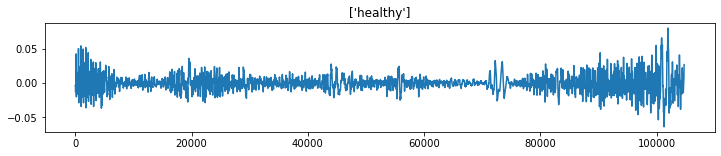

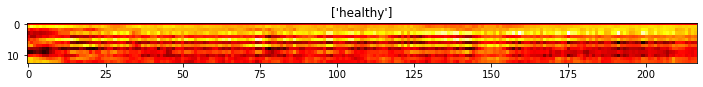

In [30]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [31]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0
 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1
 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0
 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1
 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1
 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0
 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0]


/home/nextgen/anaconda3/envs/kbs_coin/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [32]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [33]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [34]:
X_val = mfcc_features
y_val = one_hot_encoded

Model 구축

In [35]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [36]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
print(X_val.shape)

(1993, 217, 13, 1)
(400, 217, 13, 1)


In [37]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

model.compile(loss='binary_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 217, 13, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 6, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 6, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 6, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 3, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 3, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0

In [39]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
63/63 [==============================] - 11s 23ms/step - loss: 1.9589 - acc: 0.6175 - val_loss: 0.6780 - val_acc: 0.6550
Epoch 2/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6498 - acc: 0.6507 - val_loss: 0.6357 - val_acc: 0.6550
Epoch 3/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6083 - acc: 0.6653 - val_loss: 0.6257 - val_acc: 0.6550
Epoch 4/50
63/63 [==============================] - 1s 18ms/step - loss: 0.5829 - acc: 0.6785 - val_loss: 0.6104 - val_acc: 0.6550
Epoch 5/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6049 - acc: 0.6769 - val_loss: 0.6059 - val_acc: 0.6550
Epoch 6/50
63/63 [==============================] - 1s 18ms/step - loss: 0.5930 - acc: 0.6674 - val_loss: 0.6187 - val_acc: 0.6550
Epoch 7/50
63/63 [==============================] - 1s 18ms/step - loss: 0.5984 - acc: 0.6717 - val_loss: 0.6040 - val_acc: 0.6550
Epoch 8/50
63/63 [==============================] - 1s 18ms/step - loss: 0.5792 - 

loss: 0.3112604320049286
val_loss: 1.3784176111221313


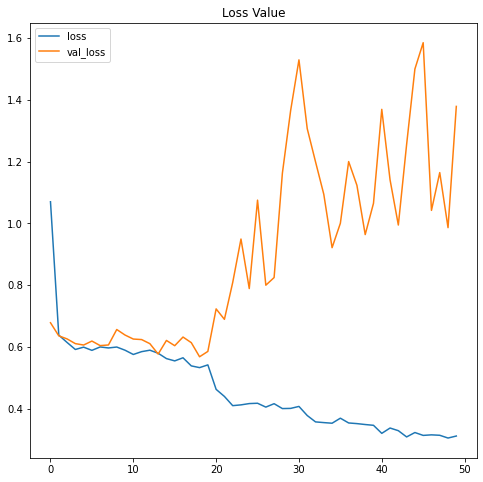

acc: 0.8670346140861511
val_acc: 0.7124999761581421


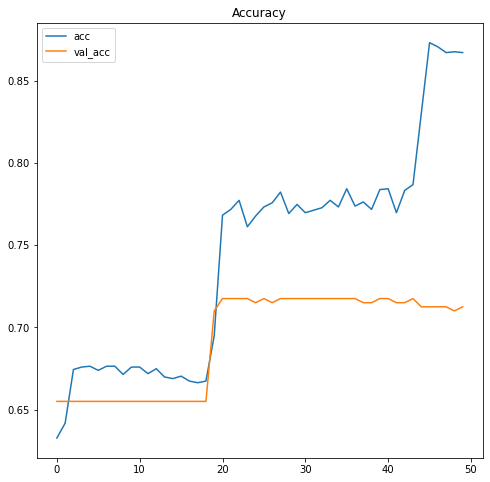

In [40]:
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [41]:
predictions = model.predict(X_val)

In [42]:
predictions = np.argmax(predictions, axis=1)
y_val = one_hot_encoder.inverse_transform(y_val)

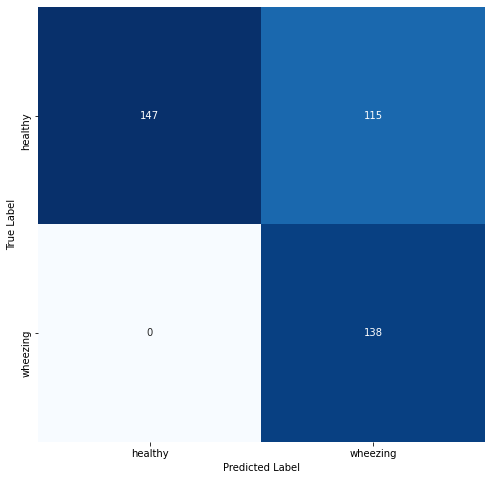

In [43]:
cm = confusion_matrix(y_val, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

하............. 개망했네

### SMOTE 라도 적용해보자...